# 东莞房价数据分析

## 分析背景：
想要了解东莞房源，设想使用数据分析和机器学习的方法来应用到房源信息上，观察东莞房价的结构。
房源信息为链家网上爬取

## 数据取得  

### 链家网上爬取房源信息的代码如下
爬取步骤为：
    1.查看是否为动态加载，发现是静态加载页面
    2.找URL规律，发现只需要1级页面即可得到所需要的信息
    3.使用正则表达式，提取网页数据
    4.将爬取的文件存入mysql数据表
    5.从mysql数据表中导出csv文件

In [ ]:
from urllib import request
import time
import re
import csv
import random
import pymysql

class LianJiaDGResoldEstateSpider(object):
    def __init__(self):
        self.url = 'https://dg.lianjia.com/ershoufang/pg{}/'
        self.ua_list = [
            'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:6.0) Gecko/20100101 Firefox/6.0',
            'User-Agent:Opera/9.80 (Windows NT 6.1; U; en) Presto/2.8.131 Version/11.11',
            'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; TencentTraveler 4.0)'            
        ]
        
        self.page = 1
        self.db = pymysql.connect('localhost','root','123456','resoldestate',charset='utf8')
        self.cursor = self.db.cursor()
            
    def get_page(self,url):
        headers = {'User-Agent':random.choice(self.ua_list)}
        req = request.Request(url=url, headers=headers)
        res = request.urlopen(req)
        html = res.read().decode('utf-8')
        
        self.parse_page(html)
           
    def parse_page(self,html):
        r = 'data-is_focus="" data-sl="">(.*?)</a>.*?data-el="region">(.*?)</a>.*?"_blank">(.*?)</a>.*?</span>(.*?)</div>.*?'
        r += 'span class="starIcon"></span>(.*?)</div>.*?<div class="totalPrice"><span>(.*?)</span>.*?'
        r += 'data-price.*?<span>(.*?)</span>'
        pattern = re.compile(r, re.S)
        r_list = pattern.findall(html)
        self.write_page(r_list)
        
    def write_page(self, r_list):
        estate_list = []
        ins = 'insert into dg_resold_estate_tb values(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)'

        for rt in r_list:
            one_estate = [ 
            rt[0].strip(),
            rt[1].strip(),
            rt[2].strip(),
            rt[3].split('|')[0].strip(),
            rt[3].split('|')[1].strip(),
            rt[3].split('|')[3].strip(),
            rt[3].split('|')[4].strip(),
            rt[3].split('|')[5].strip(),
            rt[4].strip(),
            rt[5].strip()+'万',
            rt[6].strip()[2:]
             ]
            estate_list.append(one_estate)
            
        self.cursor.executemany(ins,estate_list)
        self.db.commit()
        
        
    def main(self):
        for page in range(0,50):
            url = self.url.format(page)
            self.get_page(url)
            time.sleep(random.randint(1,3))
            print('第%d页爬取完成' % self.page)
            self.page += 1
        
        self.cursor.close()
        self.db.close()
    
if __name__ == '__main__':
    start = time.time()
    spider = LianJiaDGResoldEstateSpider()
    spider.main()
    end = time.time()
    print("执行时间:%.2f" % (start-end))

## 数据分析

In [2]:
# 绘图设置中文字体
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']

import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['KaiTi', 'Arial']})

###  数据清洗
1. 数据集完整性验证
2. 数据集中是否存在缺失值
3. 数据集中各特征数值应该如何处理
4. 哪些数据是我们想要的，哪些是可以过滤掉的
5. 将有价值数据信息做成新的数据源
6. 去除无行为交互的商品和用户
7. 去掉浏览量很大而购买量很少的用户(惰性用户或爬虫用户)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv

#### 读取数据

In [4]:
columns_name = ['adverstisement','community_name','zone','layout','area','furniture','floor','construction_time','relaese_time','total_price','unit_price']
information = pd.read_csv('dg_resold_estate.csv',
                   header=None, 
                   names=columns_name,
                   sep=",",
                   usecols=[0,1,2,3,4,5,6,7,8,9,10],
                   encoding='utf-8')

#### 打印列表长度，查看前五条记录

In [5]:
print(len(information))
information.head(5)

2550


,adverstisement,community_name,zone,layout,area,furniture,floor,construction_time,relaese_time,total_price,unit_price
0,业主急售一次性225万 全新房子 无欠款高层 朝小区,南部湾万科城,大宁,3室2厅,96.83平米,精装,中楼层(共41层),2016年建,4人关注 / 22天以前发布,225万,23237元/平米
1,东海城堡满五唯一的3房 户型采光好 位置安静,丰泰东海城堡,新联,3室2厅,89.44平米,精装,高楼层(共18层),2013年建,6人关注 / 6个月以前发布,190万,21244元/平米
2,此房好带私家码头，一线湖景，精装修，端边位大花园,银湖山庄五期,塘厦镇,7室3厅,408.37平米,精装,3层,塔楼,10人关注 / 2个月以前发布,1760万,43099元/平米
3,舒适两房 花园小区，封闭管理，地理位置好，交通方便,塞纳城市嘉园,鸿福路口,2室1厅,81平米,简装,中楼层(共30层),2008年建,31人关注 / 3个月以前发布,175万,21605元/平米
4,业主生意转型，理想0769居家过度复式小2房诚意出售,理想0769,客运总站,2室1厅,36.62平米,简装,中楼层(共10层),2006年建,8人关注 / 6天以前发布,65万,17750元/平米


#### 查看表格信息

In [5]:
information.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 11 columns):
adverstisement       2550 non-null object
community_name       2550 non-null object
zone                 2550 non-null object
layout               2550 non-null object
area                 2550 non-null object
furniture            2550 non-null object
floor                2550 non-null object
construction_time    2550 non-null object
relaese_time         2550 non-null object
total_price          2550 non-null object
unit_price           2550 non-null object
dtypes: object(11)
memory usage: 219.3+ KB


#### 检查缺失值

In [6]:
null = information.isnull()

#### 删除缺失值

In [7]:
information.dropna(how='all')

,adverstisement,community_name,zone,layout,area,furniture,floor,construction_time,relaese_time,total_price,unit_price
0,业主急售一次性225万 全新房子 无欠款高层 朝小区,南部湾万科城,大宁,3室2厅,96.83平米,精装,中楼层(共41层),2016年建,4人关注 / 22天以前发布,225万,23237元/平米
1,东海城堡满五唯一的3房 户型采光好 位置安静,丰泰东海城堡,新联,3室2厅,89.44平米,精装,高楼层(共18层),2013年建,6人关注 / 6个月以前发布,190万,21244元/平米
2,此房好带私家码头，一线湖景，精装修，端边位大花园,银湖山庄五期,塘厦镇,7室3厅,408.37平米,精装,3层,塔楼,10人关注 / 2个月以前发布,1760万,43099元/平米
3,舒适两房 花园小区，封闭管理，地理位置好，交通方便,塞纳城市嘉园,鸿福路口,2室1厅,81平米,简装,中楼层(共30层),2008年建,31人关注 / 3个月以前发布,175万,21605元/平米
4,业主生意转型，理想0769居家过度复式小2房诚意出售,理想0769,客运总站,2室1厅,36.62平米,简装,中楼层(共10层),2006年建,8人关注 / 6天以前发布,65万,17750元/平米
...,...,...,...,...,...,...,...,...,...,...,...
2545,常平镇 蓝月湾两房，精装出售 朝向好,蓝月湾,常平镇,2室1厅,67.96平米,精装,低楼层(共11层),板楼,9人关注 / 5个月以前发布,75万,11036元/平米
2546,皇朝阁 樟木头天和百货 交通便利 舒适一居 拎包即住,皇朝阁,樟木头镇,1室1厅,40.5平米,精装,中楼层(共29层),2003年建,6人关注 / 4个月以前发布,43万,10618元/平米
2547,高楼层 采光充足 厅带阳台 满五唯一 省双税费,哈啰小城,常平镇,2室2厅,81平米,简装,高楼层(共5层),2002年建,7人关注 / 4个月以前发布,93万,11482元/平米
2548,花漫里三房户型 自由设计空间 有天然气 居家舒适,鼎峰花漫里,寮步,3室2厅,92.61平米,毛坯,中楼层(共15层),2014年建,75人关注 / 4个月以前发布,102万,11014元/平米


#### 观察是否有重复记录

In [8]:
# 观察重复的记录
df1 = information.copy()
IsDuplicated = df1.duplicated()
df1_d = df1[IsDuplicated]
df1_d

,adverstisement,community_name,zone,layout,area,furniture,floor,construction_time,relaese_time,total_price,unit_price
30,业主急售一次性225万 全新房子 无欠款高层 朝小区,南部湾万科城,大宁,3室2厅,96.83平米,精装,中楼层(共41层),2016年建,4人关注 / 22天以前发布,225万,23237元/平米
31,东海城堡满五唯一的3房 户型采光好 位置安静,丰泰东海城堡,新联,3室2厅,89.44平米,精装,高楼层(共18层),2013年建,6人关注 / 6个月以前发布,190万,21244元/平米
32,此房好带私家码头，一线湖景，精装修，端边位大花园,银湖山庄五期,塘厦镇,7室3厅,408.37平米,精装,3层,塔楼,10人关注 / 2个月以前发布,1760万,43099元/平米
33,舒适两房 花园小区，封闭管理，地理位置好，交通方便,塞纳城市嘉园,鸿福路口,2室1厅,81平米,简装,中楼层(共30层),2008年建,31人关注 / 3个月以前发布,175万,21605元/平米
34,业主生意转型，理想0769居家过度复式小2房诚意出售,理想0769,客运总站,2室1厅,36.62平米,简装,中楼层(共10层),2006年建,8人关注 / 6天以前发布,65万,17750元/平米
...,...,...,...,...,...,...,...,...,...,...,...
2102,高层南向四房 大阳台格局方正 看房方便,光大景湖时代城,西平,4室2厅,172.9平米,精装,中楼层(共26层),2012年建,19人关注 / 4个月以前发布,620万,35859元/平米
2229,中联大厦 高楼层 可俯视全景虎门 带车位,中联大厦,虎门公园,3室2厅,152.25平米,精装,高楼层(共28层),2004年建,1人关注 / 31天以前发布,320万,21019元/平米
2336,松山湖北站 星城翠珑湾三期 毛坯刚需三房,星城翠珑湾三期,寮步,3室2厅,97.13平米,毛坯,高楼层(共29层),2016年建,2人关注 / 22天以前发布,321万,33049元/平米
2364,滨海湾新区虎门天虹楼上满五唯一大三房 业主诚心出售,地标广场,地标,3室2厅,167.01平米,精装,中楼层(共29层),2011年建,5人关注 / 11个月以前发布,420万,25149元/平米


In [9]:
# 观察重复的记录的数量并排序
df1_d1 = df1_d.copy()
df1_d1_size = df1_d1.groupby('adverstisement').count()
# df1_d1_size
# df1_d_size_sorted = df1_d_size.sort_values(by='adverstisement',ascending=False)
df1_d1_size_sorted = df1_d1_size.sort_values(by='community_name',ascending=False)
df1_d1_size_sorted

,community_name,zone,layout,area,furniture,floor,construction_time,relaese_time,total_price,unit_price
adverstisement,,,,,,,,,,
长城世家通透户型，精装修大四房，高层看大湖景,5,5,5,5,5,5,5,5,5,5
虎门公园旁边小区房 业主诚心出售 少有资源 有大平台,5,5,5,5,5,5,5,5,5,5
业主诚信出售 南北通透 采光好,5,5,5,5,5,5,5,5,5,5
松山湖北站旁精装两房业主诚意出售！,5,5,5,5,5,5,5,5,5,5
华远大厦 精装两房 高层 满五唯一 免个税,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...
大朗大润发旁 精装小三房 装修保养好 银行无欠款,1,1,1,1,1,1,1,1,1,1
大朗碧桂园 精装三房 保养好 税费低 环境好 看房方便,1,1,1,1,1,1,1,1,1,1
大朗碧桂园 精装三房 满五不唯一,1,1,1,1,1,1,1,1,1,1


#### 观察重复的数据结论：
发现表格中数据总计有2550行，重复有834行，不重复的有1716
分析：发现重复的数据具有一定的规律，其各列特征同样重复，且次数相同，排除房主多次发布同样信息的可能，
分析原因:可能是爬虫采集数据时造成的重复。

#### 删除重复记录

In [10]:
df2 = information.copy()
df2_nd = df2.drop_duplicates()
df2_nd[:50]

,adverstisement,community_name,zone,layout,area,furniture,floor,construction_time,relaese_time,total_price,unit_price
0,业主急售一次性225万 全新房子 无欠款高层 朝小区,南部湾万科城,大宁,3室2厅,96.83平米,精装,中楼层(共41层),2016年建,4人关注 / 22天以前发布,225万,23237元/平米
1,东海城堡满五唯一的3房 户型采光好 位置安静,丰泰东海城堡,新联,3室2厅,89.44平米,精装,高楼层(共18层),2013年建,6人关注 / 6个月以前发布,190万,21244元/平米
2,此房好带私家码头，一线湖景，精装修，端边位大花园,银湖山庄五期,塘厦镇,7室3厅,408.37平米,精装,3层,塔楼,10人关注 / 2个月以前发布,1760万,43099元/平米
3,舒适两房 花园小区，封闭管理，地理位置好，交通方便,塞纳城市嘉园,鸿福路口,2室1厅,81平米,简装,中楼层(共30层),2008年建,31人关注 / 3个月以前发布,175万,21605元/平米
4,业主生意转型，理想0769居家过度复式小2房诚意出售,理想0769,客运总站,2室1厅,36.62平米,简装,中楼层(共10层),2006年建,8人关注 / 6天以前发布,65万,17750元/平米
5,松山湖北站旁精装两房业主诚意出售！,保利红珊瑚花园,松山湖,2室2厅,80平米,精装,中楼层(共24层),2013年建,8人关注 / 2个月以前发布,330万,41250元/平米
6,黄河商圈，大莹服装城，业主诚心出售，价格可谈,东方国际星座,黄河中心,3室2厅,102.85平米,精装,中楼层(共29层),2006年建,27人关注 / 18天以前发布,142万,13807元/平米
7,精装修两房、业主自住，朝向安静，诚意出售,保利红珊瑚花园,松山湖,2室2厅,81.58平米,精装,高楼层(共24层),2013年建,6人关注 / 6天以前发布,328万,40206元/平米
8,虎门公园旁边小区房 业主诚心出售 少有资源 有大平台,能源华庄,黄河中心,3室2厅,117平米,简装,低楼层(共21层),2004年建,29人关注 / 一年前发布,205万,17522元/平米
9,万豪花园，电梯高层二房，温馨单位，格局方正采光好,万豪花园,樟木头镇,2室2厅,81平米,简装,高楼层(共31层),1998年建,13人关注 / 3个月以前发布,66.5万,8210元/平米


#### 查看数据特征

In [11]:
# 根据小区名来分组查看，并排序
df3 = df2_nd.copy()
df3_name = df3.groupby('community_name').size()
df3_name_sorted = df3_name.sort_values(ascending=False)
df3_name_sorted
# df3.groupby('community_name').agg(np.size)

community_name
中惠香樟绿洲    37
南部湾万科城    36
大运城邦      31
丰泰东海城堡    24
理想0769    20
          ..
碧水湾花园      1
礼顿金御海湾     1
信鸿熙岸花园     1
神洲大厦       1
丰泰旗山绿洲     1
Length: 525, dtype: int64

In [12]:
# 根据社区来分组查看，并排序
df3_zone = df3.groupby('zone').size()
df3_zone_sorted = df3_zone.sort_values(ascending=False)
df3_zone_sorted

zone
樟木头镇      185
凤岗镇       132
厚街镇        80
西平         66
黄江镇        65
         ... 
光大景湖湾畔      1
明苑大厦        1
理想0769      1
温塘          1
层两室\        1
Length: 74, dtype: int64

In [13]:
# 根据布局来分组查看，并排序
df3_layout = df3.groupby(['layout']).size()
df3_layout_sorted = df3_layout.sort_values(ascending=False)
df3_layout_sorted

layout
3室2厅        905
2室2厅        300
4室2厅        185
2室1厅        139
1室1厅         81
1室0厅         39
3室1厅         29
5室2厅         15
6室2厅          5
4室1厅          4
7室3厅          2
1室2厅          2
6室3厅          1
5室3厅          1
碧桂园天麓山二期      1
3室3厅          1
地标            1
宏远南           1
客运总站          1
成心出售          1
火炼树           1
证过五年\         1
dtype: int64

In [14]:
# 根据装修来分组查看，并排序
df3_furniture = df3.groupby('furniture').size()
df3_furniture_sorted = df3_furniture.sort_values(ascending=False)
df3_furniture_sorted

furniture
精装          871
简装          378
其他          261
毛坯          199
洪梅镇           1
东骏豪苑          1
58平米          1
43.95平米       1
3室2厅          1
189平米         1
114.86平米      1
dtype: int64

In [15]:
# 根据楼层来分组查看，并排序
df3_floor = df3.groupby('floor').size()
df3_floor_sorted = df3_floor.sort_values(ascending=False)
df3_floor_sorted

floor
低楼层(共18层)    67
中楼层(共18层)    62
高楼层(共18层)    60
中楼层(共11层)    56
中楼层(共17层)    42
             ..
高楼层(共5层)      1
2室2厅          1
西平            1
38层           1
中楼层(共45层)     1
Length: 125, dtype: int64

In [16]:
# 根据修建时间来分组查看，并排序
df3_time = df3.groupby('construction_time').size()
df3_time_sorted = df3_time.sort_values(ascending=False)
df3_time_sorted

construction_time
塔楼           272
2015年建       143
2013年建       129
板塔结合         108
2016年建        91
2014年建        90
2010年建        83
2012年建        78
2011年建        77
2005年建        73
2006年建        63
2008年建        61
2009年建        58
2007年建        58
1998年建        54
2017年建        43
2004年建        43
板楼            36
2003年建        32
2000年建        29
2002年建        17
1996年建        12
1995年建        11
暂无数据          10
2018年建         8
平房             7
1999年建         7
1993年建         6
1997年建         4
1994年建         2
2001年建         2
精装             1
2019年建         1
2103年建         1
4室2厅           1
77.5平米         1
中楼层(共11层)      1
中楼层(共26层)      1
低楼层(共12层)      1
11层            1
dtype: int64

#### 查看数据特征后分析：
发现部分列数据有些问题，有些列特征出现错配的情况，需要再次清理数据

#### 第二次数据清理
根据 futniture列 中的特征是否为此4类 ['精装' ，'简装' ，'毛坯' ，'其它']来清理

In [17]:
df4 = df3.copy()
furniture_type = ['精装','简装','毛坯','其他']
df4_c = df4[df4.furniture.isin(furniture_type)]
df4_c

,adverstisement,community_name,zone,layout,area,furniture,floor,construction_time,relaese_time,total_price,unit_price
0,业主急售一次性225万 全新房子 无欠款高层 朝小区,南部湾万科城,大宁,3室2厅,96.83平米,精装,中楼层(共41层),2016年建,4人关注 / 22天以前发布,225万,23237元/平米
1,东海城堡满五唯一的3房 户型采光好 位置安静,丰泰东海城堡,新联,3室2厅,89.44平米,精装,高楼层(共18层),2013年建,6人关注 / 6个月以前发布,190万,21244元/平米
2,此房好带私家码头，一线湖景，精装修，端边位大花园,银湖山庄五期,塘厦镇,7室3厅,408.37平米,精装,3层,塔楼,10人关注 / 2个月以前发布,1760万,43099元/平米
3,舒适两房 花园小区，封闭管理，地理位置好，交通方便,塞纳城市嘉园,鸿福路口,2室1厅,81平米,简装,中楼层(共30层),2008年建,31人关注 / 3个月以前发布,175万,21605元/平米
4,业主生意转型，理想0769居家过度复式小2房诚意出售,理想0769,客运总站,2室1厅,36.62平米,简装,中楼层(共10层),2006年建,8人关注 / 6天以前发布,65万,17750元/平米
...,...,...,...,...,...,...,...,...,...,...,...
2545,常平镇 蓝月湾两房，精装出售 朝向好,蓝月湾,常平镇,2室1厅,67.96平米,精装,低楼层(共11层),板楼,9人关注 / 5个月以前发布,75万,11036元/平米
2546,皇朝阁 樟木头天和百货 交通便利 舒适一居 拎包即住,皇朝阁,樟木头镇,1室1厅,40.5平米,精装,中楼层(共29层),2003年建,6人关注 / 4个月以前发布,43万,10618元/平米
2547,高楼层 采光充足 厅带阳台 满五唯一 省双税费,哈啰小城,常平镇,2室2厅,81平米,简装,高楼层(共5层),2002年建,7人关注 / 4个月以前发布,93万,11482元/平米
2548,花漫里三房户型 自由设计空间 有天然气 居家舒适,鼎峰花漫里,寮步,3室2厅,92.61平米,毛坯,中楼层(共15层),2014年建,75人关注 / 4个月以前发布,102万,11014元/平米


### 数据转换

In [18]:
df5 = df4_c.copy()
df5['area'] = df5['area'].apply(lambda x:x[:-2].strip()).astype("float")
df5['construction_time'] = df5['construction_time'].apply(lambda x:x[:-2].strip())
df5['total_price'] = df5['total_price'].apply(lambda x:float(x[:-1].strip())*10000)
df5['unit_price'] = df5['unit_price'].apply(lambda x:int(x[:-4].strip()))
df5['floor'] = df5['floor'].apply(lambda x:str(x[:3]))

print(df5.shape[0])    
df5.head()

1709


,adverstisement,community_name,zone,layout,area,furniture,floor,construction_time,relaese_time,total_price,unit_price
0,业主急售一次性225万 全新房子 无欠款高层 朝小区,南部湾万科城,大宁,3室2厅,96.83,精装,中楼层,2016,4人关注 / 22天以前发布,2250000.0,23237
1,东海城堡满五唯一的3房 户型采光好 位置安静,丰泰东海城堡,新联,3室2厅,89.44,精装,高楼层,2013,6人关注 / 6个月以前发布,1900000.0,21244
2,此房好带私家码头，一线湖景，精装修，端边位大花园,银湖山庄五期,塘厦镇,7室3厅,408.37,精装,3层,,10人关注 / 2个月以前发布,17600000.0,43099
3,舒适两房 花园小区，封闭管理，地理位置好，交通方便,塞纳城市嘉园,鸿福路口,2室1厅,81.00,简装,中楼层,2008,31人关注 / 3个月以前发布,1750000.0,21605
4,业主生意转型，理想0769居家过度复式小2房诚意出售,理想0769,客运总站,2室1厅,36.62,简装,中楼层,2006,8人关注 / 6天以前发布,650000.0,17750


In [19]:
# 数据清理
df5_1 = df5.copy()
floor_type = ['中楼层','高楼层','低楼层']
df5_c = df5_1[df5_1.floor.isin(floor_type)]
df5_c

,adverstisement,community_name,zone,layout,area,furniture,floor,construction_time,relaese_time,total_price,unit_price
0,业主急售一次性225万 全新房子 无欠款高层 朝小区,南部湾万科城,大宁,3室2厅,96.83,精装,中楼层,2016,4人关注 / 22天以前发布,2250000.0,23237
1,东海城堡满五唯一的3房 户型采光好 位置安静,丰泰东海城堡,新联,3室2厅,89.44,精装,高楼层,2013,6人关注 / 6个月以前发布,1900000.0,21244
3,舒适两房 花园小区，封闭管理，地理位置好，交通方便,塞纳城市嘉园,鸿福路口,2室1厅,81.00,简装,中楼层,2008,31人关注 / 3个月以前发布,1750000.0,21605
4,业主生意转型，理想0769居家过度复式小2房诚意出售,理想0769,客运总站,2室1厅,36.62,简装,中楼层,2006,8人关注 / 6天以前发布,650000.0,17750
5,松山湖北站旁精装两房业主诚意出售！,保利红珊瑚花园,松山湖,2室2厅,80.00,精装,中楼层,2013,8人关注 / 2个月以前发布,3300000.0,41250
...,...,...,...,...,...,...,...,...,...,...,...
2545,常平镇 蓝月湾两房，精装出售 朝向好,蓝月湾,常平镇,2室1厅,67.96,精装,低楼层,,9人关注 / 5个月以前发布,750000.0,11036
2546,皇朝阁 樟木头天和百货 交通便利 舒适一居 拎包即住,皇朝阁,樟木头镇,1室1厅,40.50,精装,中楼层,2003,6人关注 / 4个月以前发布,430000.0,10618
2547,高楼层 采光充足 厅带阳台 满五唯一 省双税费,哈啰小城,常平镇,2室2厅,81.00,简装,高楼层,2002,7人关注 / 4个月以前发布,930000.0,11482
2548,花漫里三房户型 自由设计空间 有天然气 居家舒适,鼎峰花漫里,寮步,3室2厅,92.61,毛坯,中楼层,2014,75人关注 / 4个月以前发布,1020000.0,11014


#### 查看广告词云

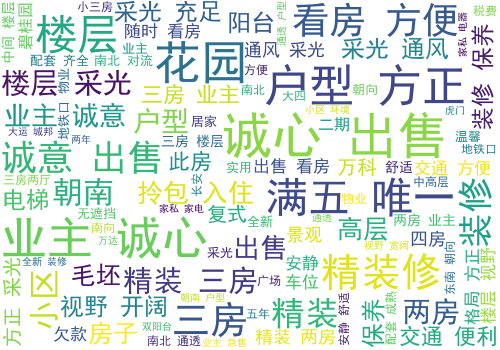

In [37]:
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import jieba
import pandas as pd

df = pd.read_csv('Deduplicated dg_resold_estate.csv',
                   header = None,
                   sep=",",
                   usecols=[1],
                   encoding='utf-8')

info = df[1].to_list()
text = ''.join(info)

cut_text = jieba.cut(text)
cut_text
result = ' '.join(cut_text)

# 生成词云图
wc = WordCloud(
    font_path = 'simhei.ttf',
    background_color='white',
    width = 500,
    height = 350,
    max_font_size = 50,    # 最大字体
    min_font_size = 10,     # 最小字体
    max_words = 100
)
wc.generate(result)
wc.to_image()

###  数据探索（理解与分析）
1. 观察数据有哪些特点，是否可利用来建模
2. 可视化展示便于分析

#### 选取需要的列

In [20]:
columns_name = ['community_name','zone','layout','area','furniture','floor','construction_time','total_price','unit_price']
df6 = df5_c[columns_name]
df6

,community_name,zone,layout,area,furniture,floor,construction_time,total_price,unit_price
0,南部湾万科城,大宁,3室2厅,96.83,精装,中楼层,2016,2250000.0,23237
1,丰泰东海城堡,新联,3室2厅,89.44,精装,高楼层,2013,1900000.0,21244
3,塞纳城市嘉园,鸿福路口,2室1厅,81.00,简装,中楼层,2008,1750000.0,21605
4,理想0769,客运总站,2室1厅,36.62,简装,中楼层,2006,650000.0,17750
5,保利红珊瑚花园,松山湖,2室2厅,80.00,精装,中楼层,2013,3300000.0,41250
...,...,...,...,...,...,...,...,...,...
2545,蓝月湾,常平镇,2室1厅,67.96,精装,低楼层,,750000.0,11036
2546,皇朝阁,樟木头镇,1室1厅,40.50,精装,中楼层,2003,430000.0,10618
2547,哈啰小城,常平镇,2室2厅,81.00,简装,高楼层,2002,930000.0,11482
2548,鼎峰花漫里,寮步,3室2厅,92.61,毛坯,中楼层,2014,1020000.0,11014


In [21]:
# 以 建筑时间 分组，查看不同建筑时间所卖房子的数量
df6_time = df6.copy()

df6_time.loc[(df6_time.construction_time == ''),'construction_time'] = 'UnKnown'
df6_time.loc[(df6_time.construction_time == '暂无'),'construction_time'] = 'UnKnown'
df6_time.loc[(df6_time.construction_time == '板塔'),'construction_time'] = 'UnKnown'
df6_time.loc[(df6_time.construction_time == '2103'),'construction_time'] = 'UnKnown'

a = df6_time.construction_time == 'UnKnown'
df6_time1 = df6_time[~a]

df_constructiontime = df6_time1.groupby('construction_time').size()
df_constructiontime_sorted = df_constructiontime.sort_values(ascending=False)
df_constructiontime_sorted.head()

construction_time
2013    122
2015    115
2014     86
2016     85
2010     81
dtype: int64

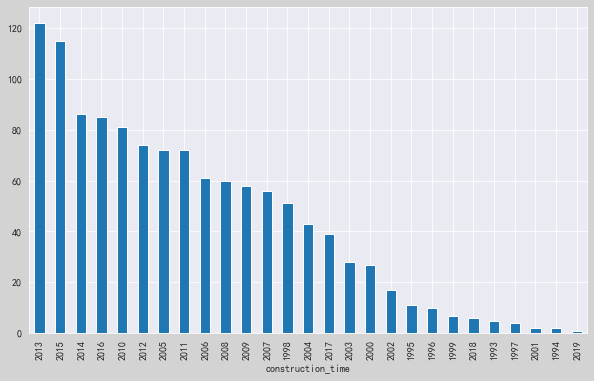

In [22]:
# 绘制条形图来观察
import matplotlib.pyplot as plt

plt.figure('bar chart',figsize=(10,6), facecolor='lightgray')
df_constructiontime_sorted.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

In [23]:
# 查看每个区域所卖房子的数量
df7 = df6_time.copy()
df_zone = df7.groupby('zone').size()
df_zone_sorted = df_zone.sort_values(ascending=False)
print(df_zone_sorted.head())
print(df_zone_sorted.tail())

zone
樟木头镇    165
凤岗镇     132
厚街镇      80
西平       66
寮步       65
dtype: int64
zone
学院路    3
胜利路    2
茶山镇    2
罗沙     2
温塘     1
dtype: int64


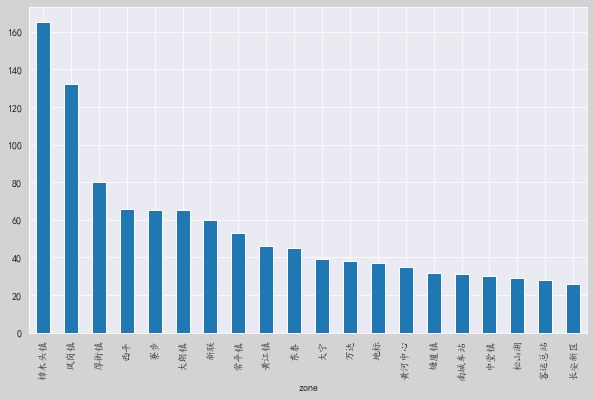

In [24]:
import matplotlib.pyplot as plt

plt.figure('bar chart',figsize=(10,6), facecolor='lightgray')
df_zone_sorted[:20].plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

In [25]:
# 查看每个区域的总价，单价，面积的平均值
df_zone_pivot = df7.pivot_table(index='zone')
# 查看每个区域的总价，均价，面积的平均值，对单价排序
df_zone_pivot_sorted = df_zone_pivot.sort_values(by='unit_price',ascending=False)
df_zone_pivot_sorted.head(10)


,area,total_price,unit_price
zone,,,
松山湖,109.860000,3.854483e+06,35117.448276
石竹,95.433043,3.233043e+06,33198.956522
南城车站,103.855806,3.170323e+06,30341.935484
西平,98.699697,3.029697e+06,30286.454545
胜利路,91.890000,2.680000e+06,29172.000000
下坝,126.626000,3.936000e+06,28320.600000
咸西,99.518182,2.737273e+06,27216.272727
宵边,92.225333,2.450000e+06,27032.533333
水濂山,146.978889,4.051111e+06,26310.555556


In [26]:
# 对面积数值进行离散化操作

df7_area_bins = df7.copy()

bins = [0,50,60,70,80,90,100,110,120,130,140,500]
# group_names = ['mid45','mid70','mid90','mid110','mid130','140up']
# cats = pd.cut(df7_area_bins.area,bins,labels=group_names)
df7_area_bins['area_bins'] = pd.cut(df7_area_bins.area,bins)
# df7_area_bins
df7_area_bins1 = df7_area_bins.groupby('area_bins').size()
df7_area_bins1.sort_values(ascending=False)

area_bins
(90, 100]     329
(80, 90]      271
(70, 80]      198
(140, 500]    145
(100, 110]    137
(110, 120]    117
(0, 50]       102
(60, 70]       90
(120, 130]     85
(50, 60]       85
(130, 140]     46
dtype: int64

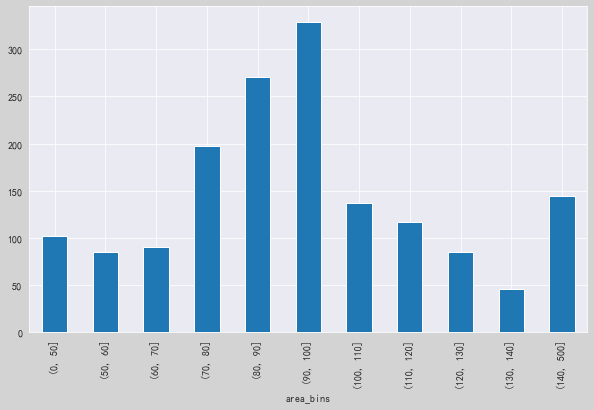

In [27]:
import matplotlib.pyplot as plt

plt.figure('bar chart',figsize=(10,6), facecolor='lightgray')
df7_area_bins1.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

In [28]:
# 查看每个区域所卖房子的户型
df7 = df7_area_bins.copy()
df_layout = df7.groupby('layout').size()
df_layout_sorted = df_layout.sort_values(ascending=False)
print(df_layout_sorted.head())
# print(df_layout_sorted.tail())

layout
3室2厅    850
2室2厅    277
4室2厅    173
2室1厅    133
1室1厅     78
dtype: int64


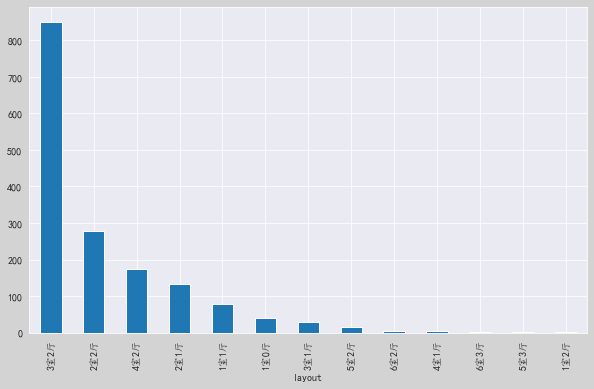

In [29]:
import matplotlib.pyplot as plt

plt.figure('bar chart',figsize=(10,6), facecolor='lightgray')
df_layout_sorted.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

In [30]:
# 查看不同小区的总价，单价，面积的平均值
df_2v_pivot = df7.pivot_table(index=['community_name'])
df_2v_pivot_sorted = df_2v_pivot.sort_values(by='unit_price',ascending=False)
df_2v_pivot_sorted.head(10)

,area,total_price,unit_price
community_name,,,
万科金域华府一期,96.792500,4300000.0,44361.750000
光大景湖时代城,119.445000,5100000.0,43722.250000
保利红珊瑚花园,89.603333,3835000.0,42648.333333
光大景湖荣郡,78.630000,3300000.0,41969.000000
万科虹溪诺雅,134.192500,5100000.0,40303.000000
鼎峰源著,273.040000,11000000.0,40288.000000
万科金域华府二期,113.276667,4525000.0,40073.166667
君珆花园,81.000000,3200000.0,39507.000000
世纪城国际公馆四期香榭里,161.270000,5875000.0,37218.500000


In [31]:
df7['area'].describe()

count    1605.000000
mean       95.719844
std        33.571506
min        30.000000
25%        76.940000
50%        92.000000
75%       109.110000
max       303.000000
Name: area, dtype: float64

In [32]:
df7['unit_price'].describe()

count     1605.000000
mean     20139.239875
std       7160.634116
min       6448.000000
25%      14815.000000
50%      19037.000000
75%      24946.000000
max      57141.000000
Name: unit_price, dtype: float64

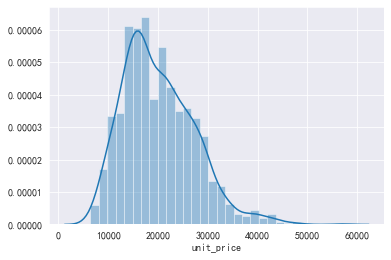

In [33]:
# 观察房屋单价的分布
sns.distplot(df7['unit_price']);

In [34]:
df7['total_price'].describe()

count    1.605000e+03
mean     1.962434e+06
std      1.081950e+06
min      2.600000e+05
25%      1.250000e+06
50%      1.780000e+06
75%      2.400000e+06
max      1.100000e+07
Name: total_price, dtype: float64

In [35]:
# 松山湖房价信息一览表
df7_1 = df7[df7.zone == '松山湖']
df7_1.describe()

,area,total_price,unit_price
count,29.000000,2.900000e+01,29.000000
mean,109.860000,3.854483e+06,35117.448276
std,32.695325,1.344419e+06,8888.125086
min,77.000000,1.300000e+06,16794.000000
25%,81.580000,3.300000e+06,30667.000000
50%,97.890000,3.800000e+06,37908.000000
75%,129.480000,4.500000e+06,41250.000000
max,188.000000,6.500000e+06,47341.000000


#### 初步分析结论
1.出售的房子年份排名前三的分别是：13年，15年，14年
2.买房最多的区域排名前三的分别是：樟木头镇，凤岗镇，厚街镇，倒数三名是:温塘,罗沙,茶山镇
3.房子单价最贵的区域排名前三的分别是：松山湖，石竹，南城车站
4.卖的最多的房子面积排名前三的分别是：(90, 100]平米，(80, 90]平米，(70, 80]平米
5.卖的最多的房子户型排名前三的分别是：3室2厅，2室2厅，4室2厅

###  数据探索（理解与分析）
1. 观察数据有哪些特点，是否可利用来建模
2. 可视化展示便于分析
3. 用户的购买意向是否随着时间等因素变化

C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


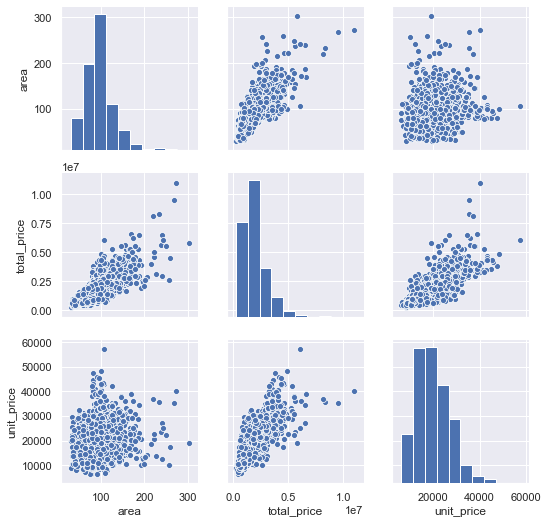

In [36]:
# 视图查看个数据的相关性
sns.set()
cols = ['area', 'total_price', 'unit_price']
sns.pairplot(df7[cols], size = 2.5)
plt.show()

# 特征工程

### 特征
二手房的基本特征：
  获取二手房特征，基于二手房本身属性多为类别特征的特点，对community_name,zone,layout，furniture，floor，area_bins
  进行标签编码操作，对于construction_time暂时不处理

In [31]:
import pickle
import math
import time
from datetime import datetime
from datetime import timedelta

In [32]:
# 标签编码
import numpy as np
import sklearn.preprocessing as sp
df8 = df7.copy()
def lbes(x):
    lbe = sp.LabelEncoder()
    result = lbe.fit_transform(df8[x])
    return result
df8

,community_name,zone,layout,area,furniture,floor,construction_time,total_price,unit_price,area_bins
0,南部湾万科城,大宁,3室2厅,96.83,精装,中楼层,2016,2250000.0,23237,"(90, 100]"
1,丰泰东海城堡,新联,3室2厅,89.44,精装,高楼层,2013,1900000.0,21244,"(80, 90]"
3,塞纳城市嘉园,鸿福路口,2室1厅,81.00,简装,中楼层,2008,1750000.0,21605,"(80, 90]"
4,理想0769,客运总站,2室1厅,36.62,简装,中楼层,2006,650000.0,17750,"(0, 50]"
5,保利红珊瑚花园,松山湖,2室2厅,80.00,精装,中楼层,2013,3300000.0,41250,"(70, 80]"
...,...,...,...,...,...,...,...,...,...,...
2545,蓝月湾,常平镇,2室1厅,67.96,精装,低楼层,UnKnown,750000.0,11036,"(60, 70]"
2546,皇朝阁,樟木头镇,1室1厅,40.50,精装,中楼层,2003,430000.0,10618,"(0, 50]"
2547,哈啰小城,常平镇,2室2厅,81.00,简装,高楼层,2002,930000.0,11482,"(80, 90]"
2548,鼎峰花漫里,寮步,3室2厅,92.61,毛坯,中楼层,2014,1020000.0,11014,"(90, 100]"


In [35]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605 entries, 0 to 2549
Data columns (total 10 columns):
community_name       1605 non-null object
zone                 1605 non-null object
layout               1605 non-null object
area                 1605 non-null float64
furniture            1605 non-null object
floor                1605 non-null object
construction_time    1605 non-null object
total_price          1605 non-null float64
unit_price           1605 non-null int64
area_bins            1605 non-null category
dtypes: category(1), float64(2), int64(1), object(6)
memory usage: 127.4+ KB


In [34]:
df8.to_csv('dg_ershoufang.csv')

In [118]:
df8['layout_labes'] = lbes('layout')
df8['community_name_labels'] = lbes('community_name')
df8['zone_labes'] = lbes('zone')
df8['furniture_labes'] = lbes('furniture')
df8['floor_labes'] = lbes('floor')
df8['area_bins_labes'] = lbes('area_bins')
df8['construction_time_labes'] = lbes('construction_time')
coloumns = ['layout','community_name','zone','furniture','floor','area_bins','construction_time']
for coloumn in coloumns:
    df8.pop(coloumn)

df8.head()
# 获取新列表的列名
# df8_1 = df8.copy()
# df8_1.columns.values.tolist()

,area,total_price,unit_price,layout_labes,community_name_labels,zone_labes,furniture_labes,floor_labes,area_bins_labes,construction_time_labes
0,96.83,2250000.0,23237,6,153,24,3,0,5,23
1,89.44,1900000.0,21244,6,94,35,3,2,4,20
3,81.00,1750000.0,21605,3,180,62,2,0,4,15
4,36.62,650000.0,17750,3,332,31,2,0,0,13
5,80.00,3300000.0,41250,4,118,37,3,0,3,20


#### 查看各特征间的相关性

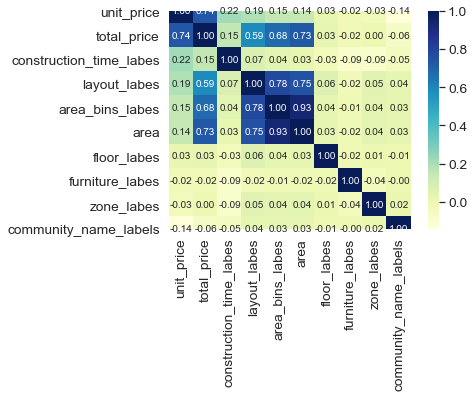

In [129]:
# 查看与单价相关的相关性指标

k = 10  
corrmat = df8.corr()
cols = corrmat.nlargest(k, 'unit_price')['unit_price'].index
cm = np.corrcoef(df8[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap='YlGnBu')
plt.show()

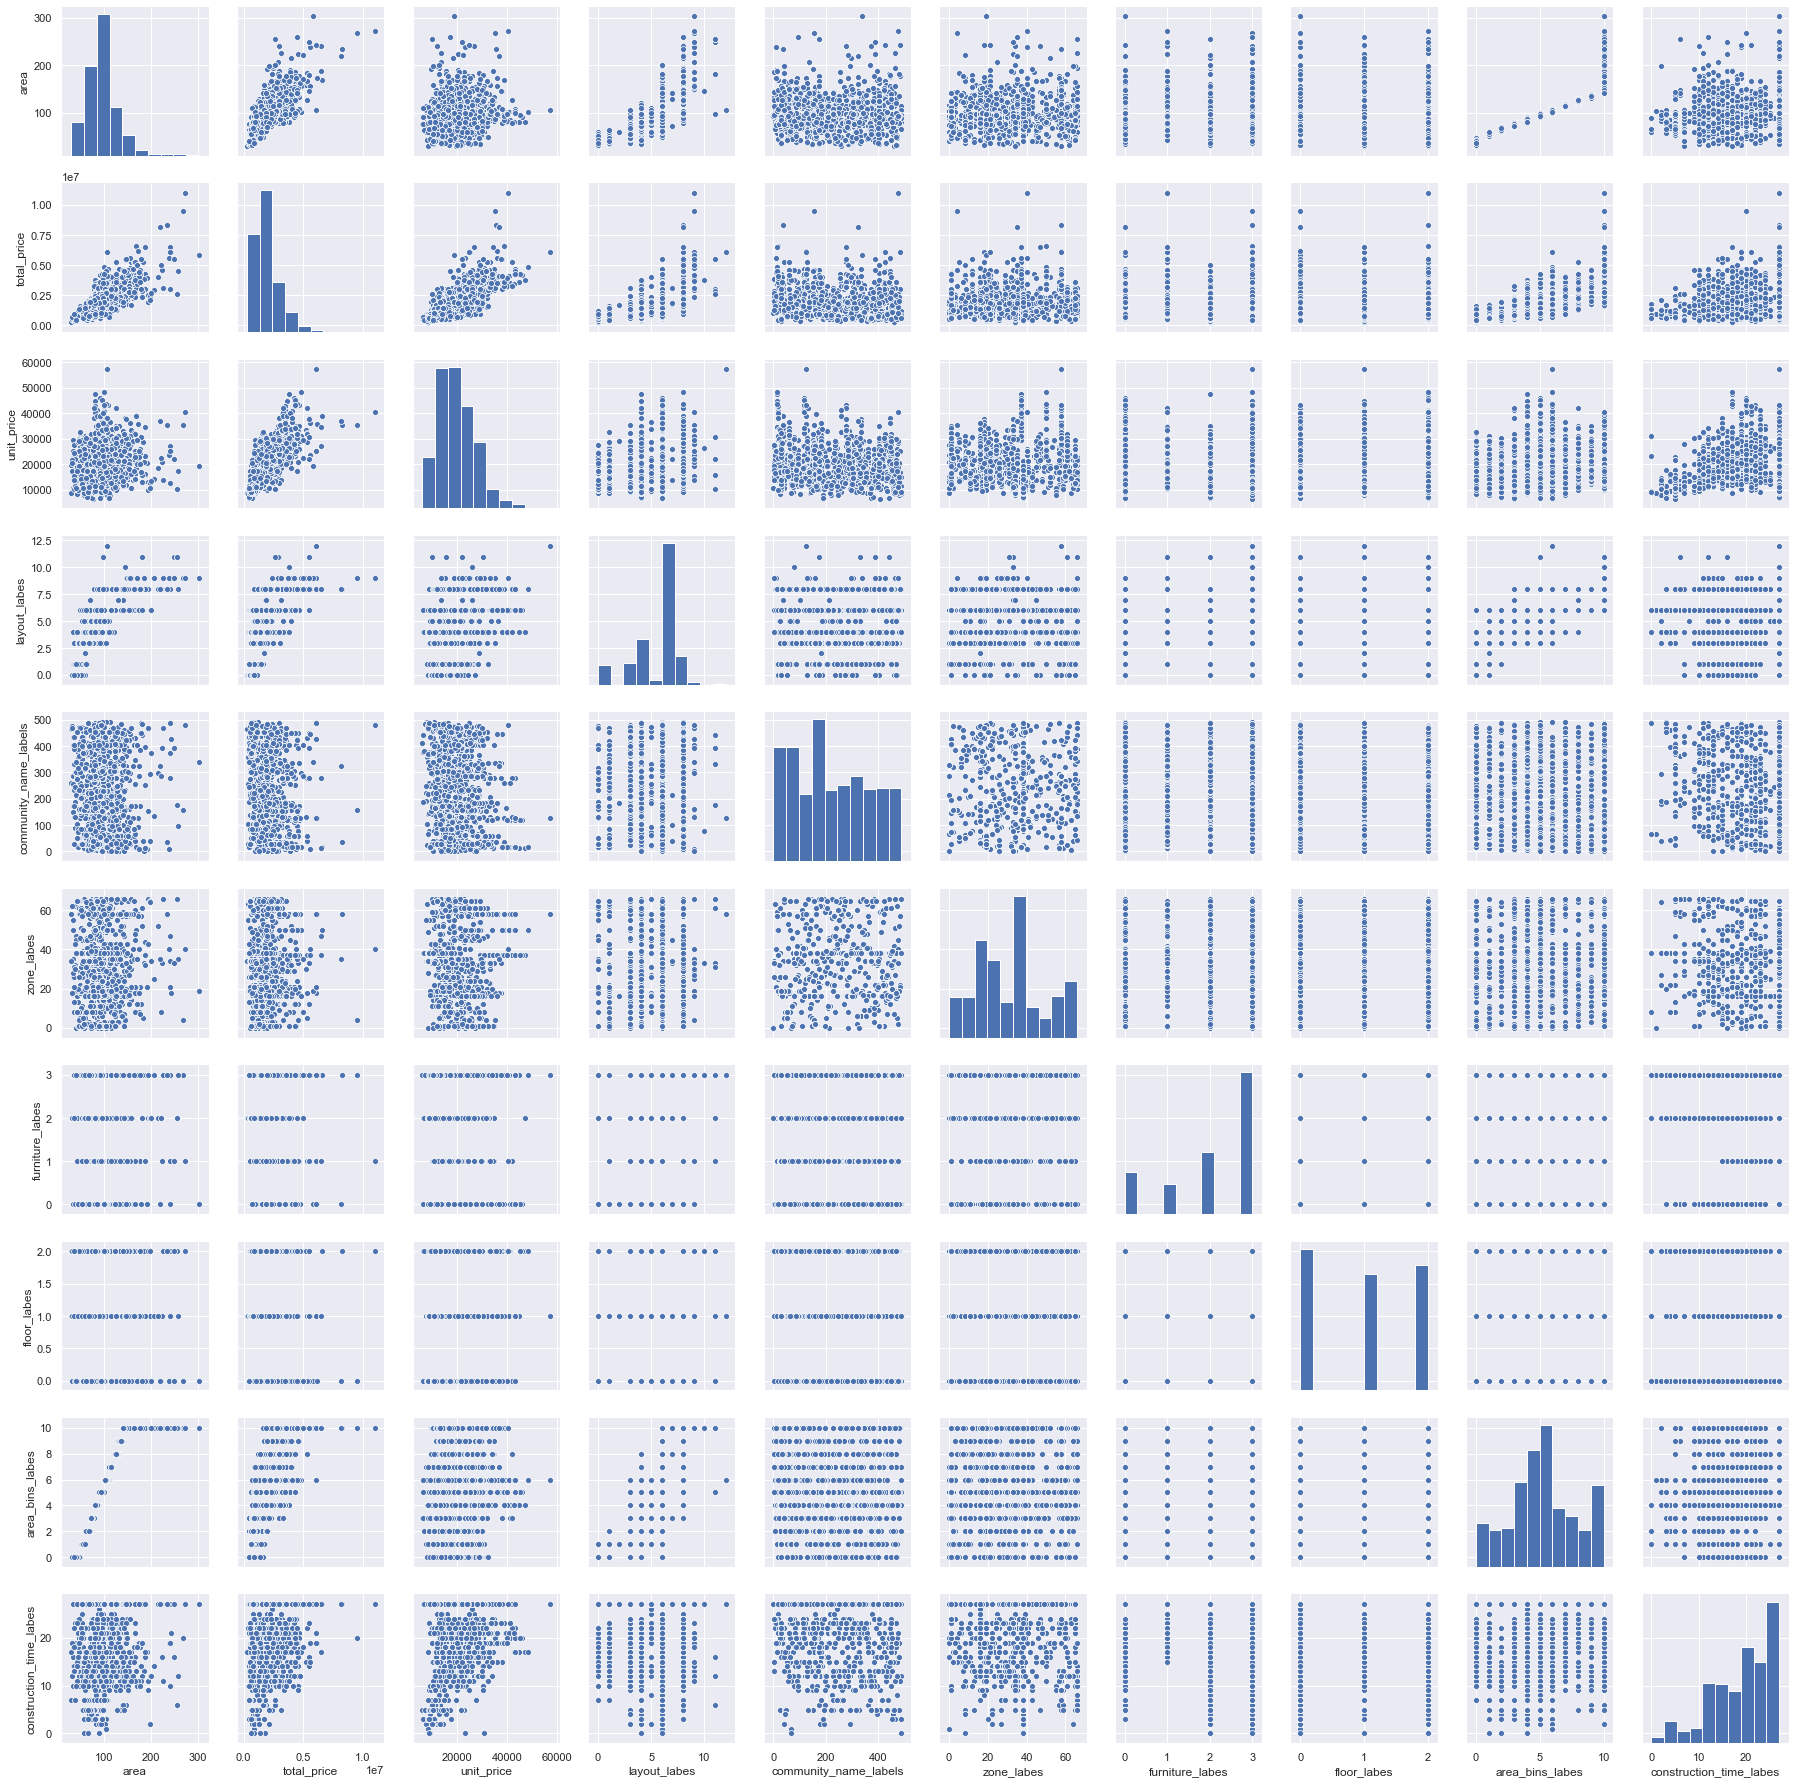

In [121]:
# 视图查看个数据的相关性
sns.set()
cols = ['area','total_price','unit_price','layout_labes','community_name_labels','zone_labes','furniture_labes','floor_labes','area_bins_labes','construction_time_labes']
sns.pairplot(df8[cols], size = 2.5)
plt.show()

In [ ]:
分析：发现各特征之间，除了单价，总价，面积，面积分类之间存在某种相关性外，其它的特征的相关性较低
采取决策树这种回归器来进行机器学习

In [151]:
# 决策树决策层为8层时的模型
import sklearn.utils as su
import sklearn.tree as st
import sklearn.metrics as sm
clos = ['area','layout_labes','community_name_labels','zone_labes','furniture_labes','floor_labes','area_bins_labes','construction_time_labes']
df8_data = df8[clos]
print("数据集维度是", df8_data.shape)
df8_target = df8['unit_price']
print("标签维度是： ",df8_target.shape)

x,y = su.shuffle(df8_data,df8_target,random_state=7)

train_size = int(len(x)*0.8)
train_x,test_x,train_y,test_y = x[:train_size],x[train_size:],y[:train_size],y[train_size:]

# 构建决策树模型，使用训练集训练
model = st.DecisionTreeRegressor(max_depth=8)

# 使用测试集测试，输出r2_score
model.fit(train_x,train_y)
pred_test_y = model.predict(test_x)
r2 = sm.r2_score(test_y,pred_test_y)
print("r2_score是： ",r2)
fi = model.feature_importances_
print("各个特征的重要性参数是： ", fi)



数据集维度是 (1605, 8)
标签维度是：  (1605,)
r2_score是：  0.38414597854793975
各个特征的重要性参数是：  [1.08715279e-01 6.92943382e-02 2.44392892e-01 3.29370966e-01
 3.46880745e-03 3.27103175e-04 1.93440065e-04 2.44237174e-01]


In [152]:
# 决策树决策层为12层时的模型
import sklearn.utils as su
import sklearn.tree as st
import sklearn.metrics as sm
clos = ['area','layout_labes','community_name_labels','zone_labes','furniture_labes','floor_labes','area_bins_labes','construction_time_labes']
df8_data = df8[clos]
print("数据集维度是", df8_data.shape)
df8_target = df8['unit_price']
print("标签维度是： ",df8_target.shape)

x,y = su.shuffle(df8_data,df8_target,random_state=7)

train_size = int(len(x)*0.8)
train_x,test_x,train_y,test_y = x[:train_size],x[train_size:],y[:train_size],y[train_size:]

# 构建决策树模型，使用训练集训练
model = st.DecisionTreeRegressor(max_depth=12)

# 使用测试集测试，输出r2_score
model.fit(train_x,train_y)
pred_test_y = model.predict(test_x)
r2 = sm.r2_score(test_y,pred_test_y)
print("r2_score是： ",r2)
fi = model.feature_importances_
print("各个特征的重要性参数是： ", fi)

数据集维度是 (1605, 8)
标签维度是：  (1605,)
r2_score是：  0.5454615403077147
各个特征的重要性参数是：  [0.14638582 0.04891976 0.23971997 0.35956069 0.01109483 0.00437577
 0.00743584 0.18250733]


In [154]:
# 自适应增强决策树回归模型，构建100棵不同的权重的决策树，训练模型
import sklearn.utils as su
import sklearn.tree as st
import sklearn.ensemble as se
import sklearn.metrics as sm
clos = ['area','layout_labes','community_name_labels','zone_labes','furniture_labes','floor_labes','area_bins_labes','construction_time_labes']
df8_data = df8[clos]
print("数据集维度是", df8_data.shape)
df8_target = df8['unit_price']
print("标签维度是： ",df8_target.shape)

x,y = su.shuffle(df8_data,df8_target,random_state=7)

train_size = int(len(x)*0.8)
train_x,test_x,train_y,test_y = x[:train_size],x[train_size:],y[:train_size],y[train_size:]

# model:决策树模型（一棵）
model = st.DecisionTreeRegressor(max_depth=8)
# 自适应增强决策树回归模型,构建100棵不同的权重的决策树
model = se.AdaBoostRegressor(model,n_estimators=100,random_state=7)

# 使用测试集测试，输出r2_score
model.fit(train_x,train_y)
pred_test_y = model.predict(test_x)
r2 = sm.r2_score(test_y,pred_test_y)
print("r2_score是： ",r2)
fi = model.feature_importances_
print("各个特征的重要性参数是： ", fi)

数据集维度是 (1605, 8)
标签维度是：  (1605,)
r2_score是：  0.7517560531764669
各个特征的重要性参数是：  [0.13475502 0.07500566 0.26016415 0.34369047 0.04541378 0.0151839
 0.01664444 0.10914257]


In [156]:
# 构建随机森林模型

import sklearn.utils as su
import sklearn.tree as st
import sklearn.ensemble as se
import sklearn.metrics as sm
clos = ['area','layout_labes','community_name_labels','zone_labes','furniture_labes','floor_labes','area_bins_labes','construction_time_labes']
df8_data = df8[clos]
print("数据集维度是", df8_data.shape)
df8_target = df8['unit_price']
print("标签维度是： ",df8_target.shape)

x,y = su.shuffle(df8_data,df8_target,random_state=7)

train_size = int(len(x)*0.8)
train_x,test_x,train_y,test_y = x[:train_size],x[train_size:],y[:train_size],y[train_size:]

# 自适应增强决策树回归模型,构建50棵不同的权重的决策树
model = se.RandomForestRegressor(max_depth=8,n_estimators=100,min_samples_split=2)

# 使用测试集测试，输出r2_score
model.fit(train_x,train_y)
pred_test_y = model.predict(test_x)
r2 = sm.r2_score(test_y,pred_test_y)
print("r2_score是： ",r2)
fi = model.feature_importances_
print("各个特征的重要性参数是： ", fi)

数据集维度是 (1605, 8)
标签维度是：  (1605,)
r2_score是：  0.6290501451521149
各个特征的重要性参数是：  [0.11926313 0.05915657 0.22764422 0.31992916 0.01779382 0.00624731
 0.01577355 0.23419226]
